<a href="https://colab.research.google.com/github/edcalderin/BreastCancerDetection_CNN/blob/master/cnn_breast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WomanLife

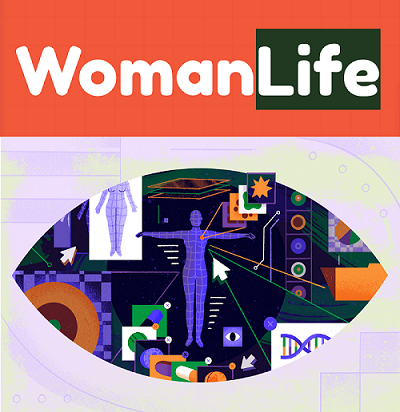


Proyecto final en SaturdaysAI La Paz, para la detección y clasificación de cáncer de mama en mujeres de 25 a 75 años de edad a partir de imágenes de ultrasonido.

Agradacimiento a los autores del sitio web por proveer una fuente de imágenes abiertas para propósitos de investigación: 

https://scholar.cu.edu.eg/?q=afahmy/pages/dataset


*   Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

## Modulos

In [ ]:
# Módulos de Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
print(tf.__version__)

# Tensorboard
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorboard import notebook

# Deployment
from tensorflow import lite

2.7.0


In [ ]:
# Utilidades
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Lectura de datos

Si utilizas las imagenes desde la fuente de datos orignal, entonces ejecuta las siguientes instrucciones:  
* Borrar imágenes de máscaras que no aportan información significativa al modelo. Para ello debes ejectuar las sentencias Shell comentadas e ir
cambiando el nombre del directorio al final de la ruta para acceder a las otras clasificaciones.

In [ ]:
#%cd '/content/drive/SaturdaysAI/Dataset_BUSI_with_GT/normal/'
#%rm *mask*.png

# Deben existir 437, 210 y 133 imagenes en los directorios benign, malignant y normal, respectivamente para un total de 780 imágenes

**VARIABLES DE CONFIGURACIÓN GLOBAL:**

In [ ]:
BATCH_SIZE = 64
SEED = 1234
EPOCHS = 30
LEARNING_RATE = 0.0001
INPUT_SHAPE = (224, 224, 3)

Datos para Train y Test:

In [ ]:
# Directorio
PATH = '/content/drive/MyDrive/SaturdaysAI'

# Parametros reutilizables
PARAMS = dict(directory = PATH+'/Dataset_BUSI_with_GT', 
              seed = SEED, 
              label_mode='int',              
              validation_split = 0.2,
              batch_size = BATCH_SIZE, 
              image_size = INPUT_SHAPE[:2])

train_set = keras.preprocessing.image_dataset_from_directory(**PARAMS, subset='training')
test_set = keras.preprocessing.image_dataset_from_directory(**PARAMS, subset='validation')

Found 780 files belonging to 3 classes.
Using 624 files for training.
Found 780 files belonging to 3 classes.
Using 156 files for validation.


In [ ]:
class_names = train_set.class_names
print(class_names)

['benign', 'malignant', 'normal']


In [ ]:
%%time
images, labels = next(iter(train_set))

CPU times: user 5.72 s, sys: 672 ms, total: 6.39 s
Wall time: 5.11 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

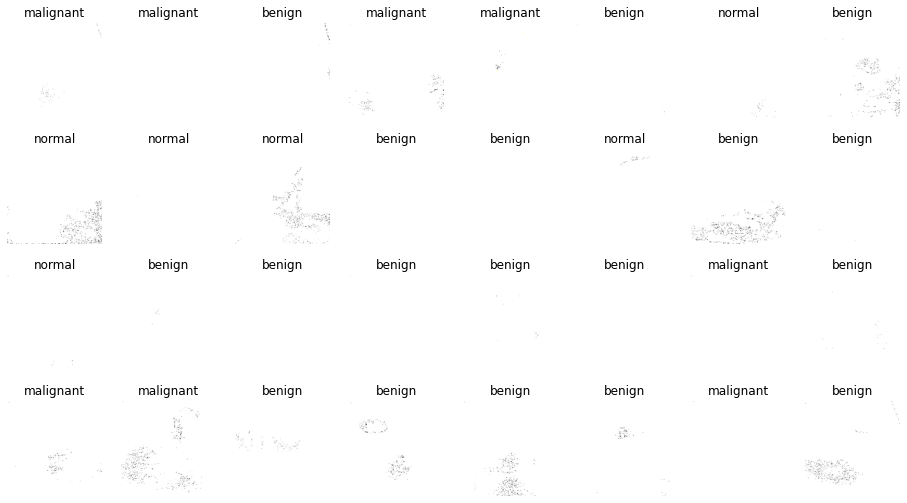

In [ ]:
fig = plt.figure(figsize=(16, 10))
axes = fig.subplots(4, 8)
fig.subplots_adjust(bottom=0, top=.7, hspace=0, wspace=0.2)
for ax, image, label in zip(axes.flatten(), images, labels):
    ax.set_title(class_names[label])
    ax.imshow(np.squeeze(image), cmap='gray')
    ax.axis('off')

## Creacion de la red neuronal

Model Subclassing para la creación de la red neuronal

In [ ]:
vgg16 = VGG16(include_top=False, input_shape=INPUT_SHAPE)

In [ ]:
for layer in vgg16.layers:
    layer.trainable=False

In [ ]:
def base_model(num_classes, learning_rate=0.0001):
    x = layers.Flatten()(vgg16.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])
    return model

In [ ]:
model = base_model(len(class_names))

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Entrenamiento

Detención temprana:

In [ ]:
earlyStopping_callback = EarlyStopping(monitor='val_accuracy', verbose=2, patience=EPOCHS//4)

In [ ]:
model.fit(train_set, validation_data=test_set, epochs=30, batch_size=32, 
          verbose=2, callbacks=[earlyStopping_callback]
        )

Epoch 1/30
10/10 - 12s - loss: 2.9389 - accuracy: 0.4776 - val_loss: 0.9360 - val_accuracy: 0.6987 - 12s/epoch - 1s/step
Epoch 2/30
10/10 - 11s - loss: 0.6896 - accuracy: 0.7981 - val_loss: 0.7162 - val_accuracy: 0.7115 - 11s/epoch - 1s/step
Epoch 3/30
10/10 - 11s - loss: 0.2787 - accuracy: 0.8926 - val_loss: 0.7473 - val_accuracy: 0.7436 - 11s/epoch - 1s/step
Epoch 4/30
10/10 - 11s - loss: 0.1574 - accuracy: 0.9359 - val_loss: 0.7404 - val_accuracy: 0.7628 - 11s/epoch - 1s/step
Epoch 5/30
10/10 - 11s - loss: 0.0946 - accuracy: 0.9663 - val_loss: 0.6612 - val_accuracy: 0.7885 - 11s/epoch - 1s/step
Epoch 6/30
10/10 - 11s - loss: 0.0535 - accuracy: 0.9792 - val_loss: 0.7419 - val_accuracy: 0.7372 - 11s/epoch - 1s/step
Epoch 7/30
10/10 - 11s - loss: 0.0335 - accuracy: 0.9952 - val_loss: 0.6996 - val_accuracy: 0.7949 - 11s/epoch - 1s/step
Epoch 8/30
10/10 - 11s - loss: 0.0273 - accuracy: 0.9920 - val_loss: 0.6078 - val_accuracy: 0.8013 - 11s/epoch - 1s/step
Epoch 9/30
10/10 - 11s - loss: 0

## Validación

In [ ]:
model.evaluate(test_set)

3/3 [==============================] - 2s 372ms/step - loss: 0.7542 - accuracy: 0.7821


[0.7541956305503845, 0.7820512652397156]

In [ ]:
# Visualización del dashboard de Tensorboard una vez entrenado el modelo. Descomentar para desplegar TensorBoard
notebook.display(port=6006, height=1000)

<IPython.core.display.Javascript object>

## Despliegue

**Arquitectura de desarrollo:**

El modelado generado cno Keras será guardado y reutilizará con Tensorflow Lite para llevar a cabo la conversión del modelo.
Finalmente, la aplicación móvil, desarrollada en Flutter (https://flutter.dev/), tendrá el modelo embebido dentro de los asset. Se seleccinó Flutter ya que cuenta con widgets especiales para la lectura de modelos con Tensorflow Lite. Adicionalmente, tanto Tensorflow y Flutter son tecnologías desarrolladas por Google (Flutter fué liberado hace pocos años) lo que facilita la integración punta a punta.

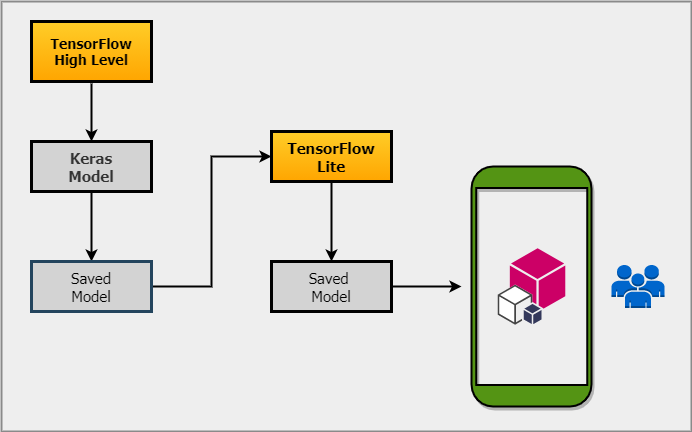

**Guardando el modelo:**

Los modelos y cualquier otro recurso generado en éste notebook se guarda directamente en nuestro espacio de almacenamiento de Google Drive.

In [ ]:
PATH_MODEL = PATH+'/models/tf_breast_cancer_model'

In [ ]:
tf.saved_model.save(model, PATH_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SaturdaysAI/models/tf_breast_cancer_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SaturdaysAI/models/tf_breast_cancer_model/assets


**Conversión a TensorFlow Lite**

In [ ]:
PATH_TFLITE_MODEL = PATH+'/models/tflite_cancer_model.tflite'

In [ ]:
converter = lite.TFLiteConverter.from_saved_model(PATH_MODEL)
tflite_model = converter.convert()

In [ ]:
open(PATH_TFLITE_MODEL, "wb").write(tflite_model)

42850640